In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from ISLP import confusion_table
from sklearn.metrics import RocCurveDisplay
from dataset import vif_featuretrimmer

c:\Users\bicic\Documents\bachelor\dataset.py:76: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df['year'] = df['calendarYear'].combine_first(
c:\Users\bicic\Documents\bachelor\dataset.py:77: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df['calendarYear_x']).combine_first(df['calendarYear_y'])


Load dataset and display basic information about it

In [2]:
df = pd.read_csv('./datasets/full_cleaned_dataset.csv')
df.info()

print("Example of a row in the dataset:\n")
print(df.sample(1).to_markdown(index=False))
print("\n")
print(f"The dataset consists of {df['symbol'].nunique()} companies")
print(f"spannign from {df['year'].min()} to {df['year'].max()}\n")
print("Each row contains the cash flow statements, the balance sheets, and the income statements of a company for a given year.\n")
print("All of the companies are or were listed on the Swiss stock exchange. Companies that have been delisted, or have announced their wish to delist are marked as distressed.\n")
print(f"Out of the {df['distressed'].count()} observations, {df['distressed'].sum()} are distressed.")
print(f"This means the dataset is imbalanced, with only {df['distressed'].sum()/df['distressed'].count()*100:.2f}% of the companies being distressed.\n")

print("The dataset contains the following missing values:\n")
print(df.isna().sum().to_markdown())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Columns: 110 entries, date to marketcap
dtypes: float64(91), int64(14), object(5)
memory usage: 791.6+ KB
Example of a row in the dataset:

| date       | symbol   | currency_balance_sheet   |   cashAndCashEquivalents |   shortTermInvestments |   cashAndShortTermInvestments |   netReceivables |   inventory_balance_sheet |   otherCurrentAssets |   totalCurrentAssets |   propertyPlantEquipmentNet |   goodwill |   intangibleAssets |   goodwillAndIntangibleAssets |   longTermInvestments |   taxAssets |   otherNonCurrentAssets |   totalNonCurrentAssets |   otherAssets |   totalAssets |   accountPayables |   shortTermDebt |   taxPayables |   deferredRevenue |   otherCurrentLiabilities |   totalCurrentLiabilities |   longTermDebt |   deferredRevenueNonCurrent |   deferredTaxLiabilitiesNonCurrent |   otherNonCurrentLiabilities |   totalNonCurrentLiabilities |   otherLiabilities |   capitalLeaseObligations |   totalLiabilit

We see that the dataset has a large number of features. Most of them numerical. The target variable (distressed) is categorical. However the dataset is highly imbalanced. We must find ways to deal with the imbalance.

Calcualte the Altman-Z score for each observation (where possible) and show the top and bottom 5 companies based on the Altman-Z score. Since we don't have the market cap for all companies, we cannot calculate the Altman Z-score for all companies.

In [3]:
df_zscore = df.copy()
df_zscore["z_score"] = 1.2*(df["totalCurrentAssets"]/df["totalAssets"]) + 1.4*df["retainedEarnings"]/df["totalAssets"] + 3.3 * (df["ebitda"]-df["depreciationAndAmortization_income_statement"])/df["totalAssets"] + 0.6*df["marketcap"] / df["totalLiabilities"] + 0.999*df["revenue"]/df["totalAssets"]
df_zscore["z_score"] = df_zscore["z_score"].round(2)
df_zscore.dropna(subset=['z_score'], inplace=True)

df_zscore_print = df_zscore[['symbol', 'year', 'z_score', 'distressed']]
print(df_zscore_print.sort_values(by=['z_score'], ascending=False).head(10))
print(df_zscore_print.sort_values(by=['z_score'], ascending=True).head(10))

      symbol  year  z_score  distressed
141  BION.SW  2020    46.41           0
105  BANB.SW  2021    41.12           0
296  EMSN.SW  2021    35.45           0
144  BEAN.SW  2021    34.99           0
142  BEAN.SW  2023    34.77           0
297  EMSN.SW  2020    33.59           0
145  BEAN.SW  2020    32.48           0
294  EMSN.SW  2023    32.25           0
661  SENS.SW  2023    26.94           0
663  SENS.SW  2021    25.52           0
      symbol  year  z_score  distressed
16   ADXN.SW  2023  -113.64           0
17   ADXN.SW  2022   -64.61           0
18   ADXN.SW  2021   -16.77           0
19   ADXN.SW  2020   -15.86           0
638  SANN.SW  2022   -15.77           0
397  IDIA.SW  2023    -9.46           0
640  SANN.SW  2020    -9.39           0
639  SANN.SW  2021    -9.15           0
853  WIHN.SW  2023    -7.41           0
854  WIHN.SW  2022    -6.28           0


Let's do some general exploration of this new dataset.

In [4]:
print("Example of a row in the dataset:\n")
print(df_zscore.sample(1).to_markdown(index=False))
print("\n")
print(f"The dataset consists of {df_zscore['symbol'].nunique()} companies")
print(f"and {df_zscore['symbol'].count()} observations")
print(f"spannign from {df_zscore['year'].min()} to {df_zscore['year'].max()}\n")
print(f"Out of the {df_zscore['distressed'].count()} observations, {df_zscore['distressed'].sum()} are distressed.")
print(f"This means the dataset is imbalanced, with only {df_zscore['distressed'].sum()/df_zscore['distressed'].count()*100:.2f}% of the companies being distressed.\n")
print(f"The Altman Z-score has a mean of {df_zscore['z_score'].mean():.2f} and a standard deviation of {df_zscore['z_score'].std():.2f}.")

print("The dataset contains the following missing values:\n")
print(df_zscore.isna().sum().to_markdown())

Example of a row in the dataset:

| date       | symbol   | currency_balance_sheet   |   cashAndCashEquivalents |   shortTermInvestments |   cashAndShortTermInvestments |   netReceivables |   inventory_balance_sheet |   otherCurrentAssets |   totalCurrentAssets |   propertyPlantEquipmentNet |   goodwill |   intangibleAssets |   goodwillAndIntangibleAssets |   longTermInvestments |   taxAssets |   otherNonCurrentAssets |   totalNonCurrentAssets |   otherAssets |   totalAssets |   accountPayables |   shortTermDebt |   taxPayables |   deferredRevenue |   otherCurrentLiabilities |   totalCurrentLiabilities |   longTermDebt |   deferredRevenueNonCurrent |   deferredTaxLiabilitiesNonCurrent |   otherNonCurrentLiabilities |   totalNonCurrentLiabilities |   otherLiabilities |   capitalLeaseObligations |   totalLiabilities |   preferredStock |   commonStock |   retainedEarnings |   accumulatedOtherComprehensiveIncomeLoss |   othertotalStockholdersEquity |   totalStockholdersEquity |   totalEqui

The Altman-Z score is usually interpreted as follows:
- Z > 3.0: Safe zone
- 1.8 < Z < 3.0: Grey zone
- Z < 1.8: Distress zone

Looking at the top and bottom 10, we get very extreme values (above 25 and below -6) which are likely due to faulty, inaccurate or missing data. These entries should be considered as outliers and removed for further analysis.
Interestingly, in the bottom 10, we don't have companies that we considered to be distressed. In a next step let's take a look at the score of the distressed companies.

In [5]:
print(df_zscore_print.where(df_zscore_print['distressed'] == 1).sort_values(by=['z_score'], ascending=False).dropna())

      symbol    year  z_score  distressed
910  STLN.SW  2022.0     2.43         1.0
911  STLN.SW  2021.0     2.24         1.0
909  STLN.SW  2023.0     1.39         1.0
912  STLN.SW  2020.0     0.82         1.0
901  CSGN.SW  2022.0     0.46         1.0
902  CSGN.SW  2021.0     0.41         1.0
903  CSGN.SW  2020.0     0.39         1.0
904  CSGN.SW  2019.0     0.35         1.0


We can see the the Altman-Z score does seem to be a decent indicator in the case of our distressed companies.
CSGN (Credit Suisse) does have a very low score.
STLN (Swiss Steel Holding) had a low score in 2020, but it recovered in later years. Checking the news, it shows that the company went through rebranding, after some stressful years. In 2023 it dropped again, fitting with their wish to remove themselves from the stock market.

We still have an highly imbalanced dataset. We could try to use the Z-score to define a new threshold instead of distressed. We can call it "unhealthy" and set the threshold to 3.0 for the Z-Score, then check the balance of the dateset again.

In [6]:
df_zscore['unhealthy'] = df_zscore['z_score'].apply(lambda x: 1 if x < 3.00 else 0)

In [7]:
print(f"Out of the {df_zscore['unhealthy'].count()} observations, {df_zscore['unhealthy'].sum()} are deemed to be in a financially unhealthy stage.")
print(f"Balance of the dataset is as follows, with {df_zscore['unhealthy'].sum()/df_zscore['unhealthy'].count()*100:.2f}% of the companies being unhealthy.\n")


Out of the 731 observations, 342 are deemed to be in a financially unhealthy stage.
Balance of the dataset is as follows, with 46.79% of the companies being unhealthy.



Setting the thresholf to 3.0 gave us a well balanced dataset, but we have to keep in mind that we're now looking determining "unhealthy" companies, not companies that might default.

Now let's look at the distribution just numerically and visually in a histogram.

count    731.000000
mean       4.031108
std        7.489369
min     -113.640000
25%        1.325000
50%        3.230000
75%        5.750000
max       46.410000
Name: z_score, dtype: float64
|   Unhealthy |   Count |
|------------:|--------:|
|           0 |     389 |
|           1 |     342 |


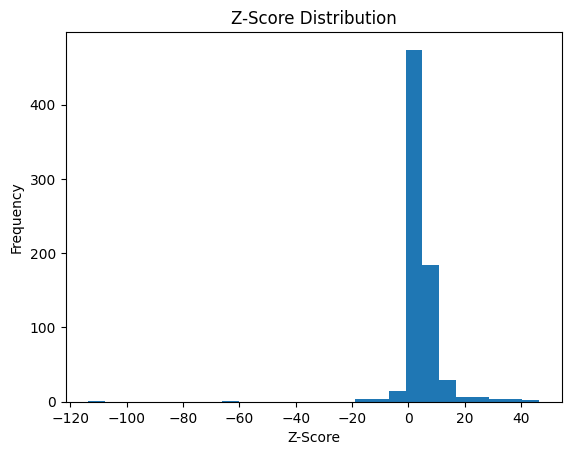

In [8]:
print(df_zscore['z_score'].describe())
print(df_zscore['unhealthy'].value_counts().to_markdown(index=True, headers=['Unhealthy', 'Count'], tablefmt='pipe'))

# Histogram
bins =  int(math.sqrt(len(df_zscore.index))) # number of bins based on square root of number of data points
plt.hist(df_zscore['z_score'], bins=bins)
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()



This is just another proof that there are extreme outliers in the data.
Let's remove the outliers based the standard deviation (7.48) and see how the distribution looks like.

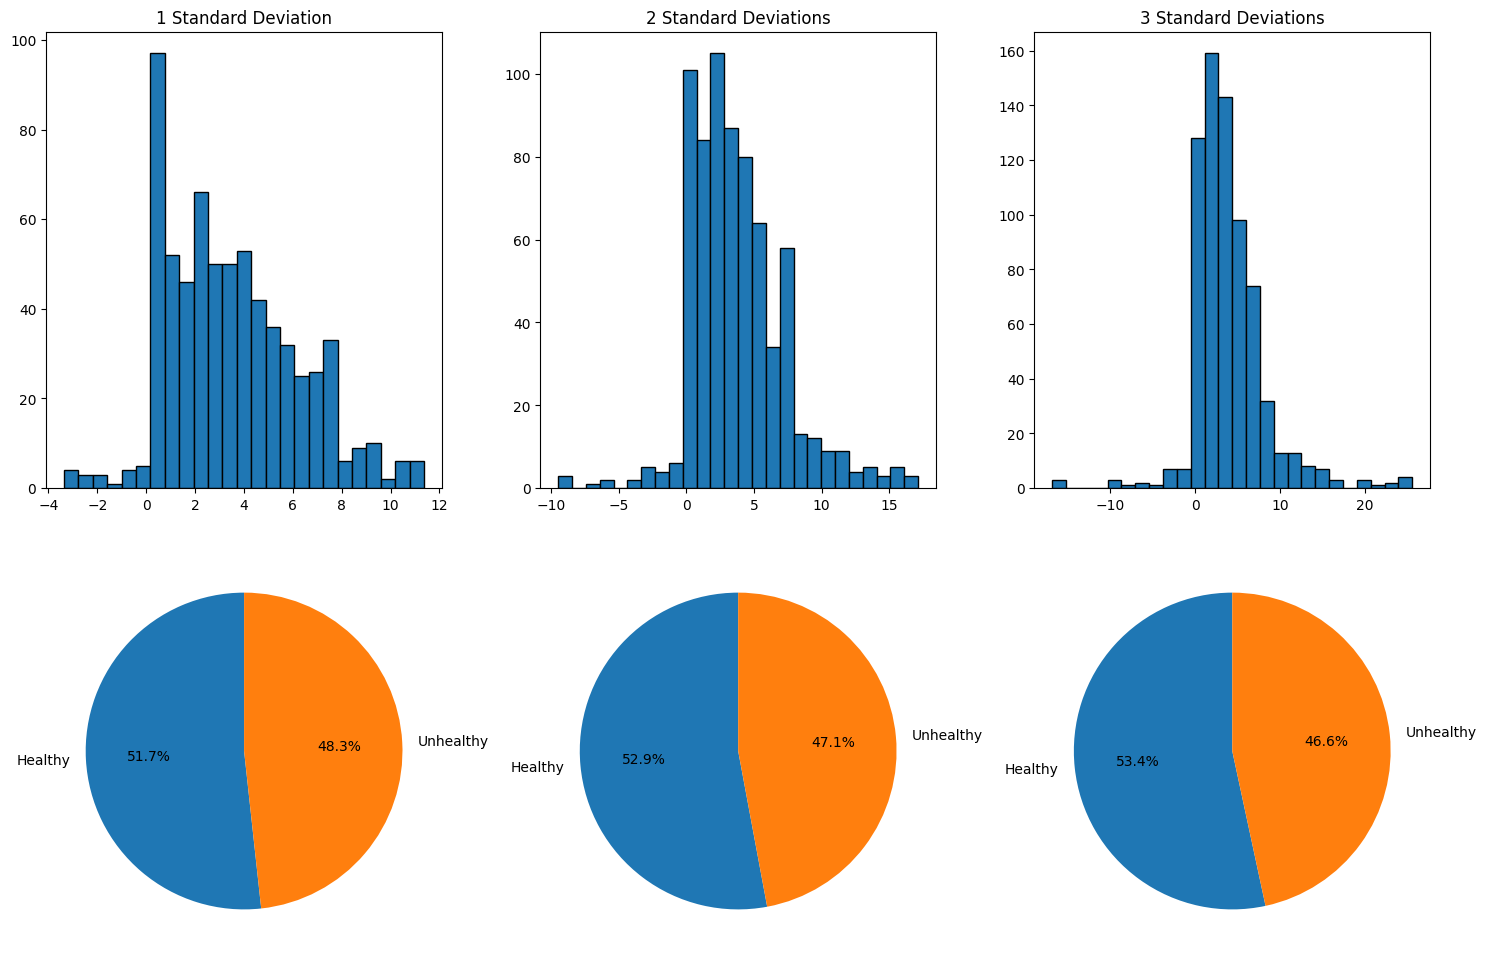

In [9]:
std = 7.49
mean = 4.03

df_1std = df_zscore.where(
    (df_zscore['z_score'] >= mean - std) & (df_zscore['z_score'] <= mean + std)).dropna()
df_2std = df_zscore.where(
    (df_zscore['z_score'] >= mean - 2*std) & (df_zscore['z_score'] <= mean + 2*std)).dropna()
df_3std = df_zscore.where(
    (df_zscore['z_score'] >= mean - 3*std) & (df_zscore['z_score'] <= mean + 3*std)).dropna()

bins1 = int(math.sqrt(len(df_1std.index)))
bins2 = int(math.sqrt(len(df_2std.index)))
bins3 = int(math.sqrt(len(df_3std.index)))

fig, axs = plt.subplots(
    2, 3, sharey=False, tight_layout=False, figsize=(15, 10))
axs[0, 0].hist(df_1std['z_score'], bins=bins1, edgecolor='black')
axs[0, 0].set_title('1 Standard Deviation')
axs[1, 0].pie(df_1std['unhealthy'].value_counts(), labels=[
              'Healthy', 'Unhealthy'], autopct='%1.1f%%', startangle=90)
axs[0, 1].hist(df_2std['z_score'], bins=bins2, edgecolor='black')
axs[0, 1].set_title('2 Standard Deviations')
axs[1, 1].pie(df_2std['unhealthy'].value_counts(), labels=[
              'Healthy', 'Unhealthy'], autopct='%1.1f%%', startangle=90)
axs[0, 2].hist(df_3std['z_score'], bins=bins3, edgecolor='black')
axs[0, 2].set_title('3 Standard Deviations')
axs[1, 2].pie(df_3std['unhealthy'].value_counts(), labels=[
              'Healthy', 'Unhealthy'], autopct='%1.1f%%', startangle=90)
plt.show()

Staying within up to 3 standard deviations we're removing a lot of extreme cases, while still keeping a lot of the data all the while not loosing any balance.
But even after removing all the extreme observations the mean is still very high at 3.9 (for 3 stds). The expected mean should be closer to 1.8, which is also the cutoff point for the grey zone according to Altman. However, considering that the data we're working with aren't just random companies, but sourced from a high perfoming index, this might be a reasonable result. Going forward we should keep using this 3rd standard deviation set as our dataset.

Interesting are the companies with negative scores, let's take a look at them.

A correlation matrix is a good way to visualize the relationships between the variables. This might give us insight into the behind the negative Z-scores and explain how these outliers are formed.

In [10]:
negative_scores = df_3std.where(df_3std['z_score']<0).dropna()
negative_z_score_analysis = negative_scores[['symbol', 'year', 'z_score', 'totalCurrentAssets', 'totalAssets', 'retainedEarnings', 'ebitda', 'depreciationAndAmortization_income_statement', 'totalLiabilities', 'marketcap', 'revenue']]


Since the Z-score is based on 5 ratios and not just the raw variables, we should also create a matrix with those ratios. These ratios should have a stronger correlation to the Z-score, comparitively.

In [11]:
negative_z_score_analysis['ebit'] = negative_z_score_analysis['ebitda'] - negative_z_score_analysis['depreciationAndAmortization_income_statement']
negative_z_score_analysis = negative_z_score_analysis.drop(columns=['ebitda', 'depreciationAndAmortization_income_statement'])
negative_z_score_analysis['A'] = negative_z_score_analysis['totalCurrentAssets'] / negative_z_score_analysis['totalAssets']
negative_z_score_analysis['B'] = negative_z_score_analysis['retainedEarnings'] / negative_z_score_analysis['totalAssets']
negative_z_score_analysis['C'] = negative_z_score_analysis['ebit'] / negative_z_score_analysis['totalAssets']
negative_z_score_analysis['D'] = negative_z_score_analysis['marketcap'] / negative_z_score_analysis['totalLiabilities']
negative_z_score_analysis['E'] = negative_z_score_analysis['revenue'] / negative_z_score_analysis['totalAssets']

negative_z_score_analysis.to_csv('./datasamples/negative_z_score_analysis.csv', index=False)

C:\Users\bicic\AppData\Local\Temp\ipykernel_12440\3429416264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_z_score_analysis['ebit'] = negative_z_score_analysis['ebitda'] - negative_z_score_analysis['depreciationAndAmortization_income_statement']


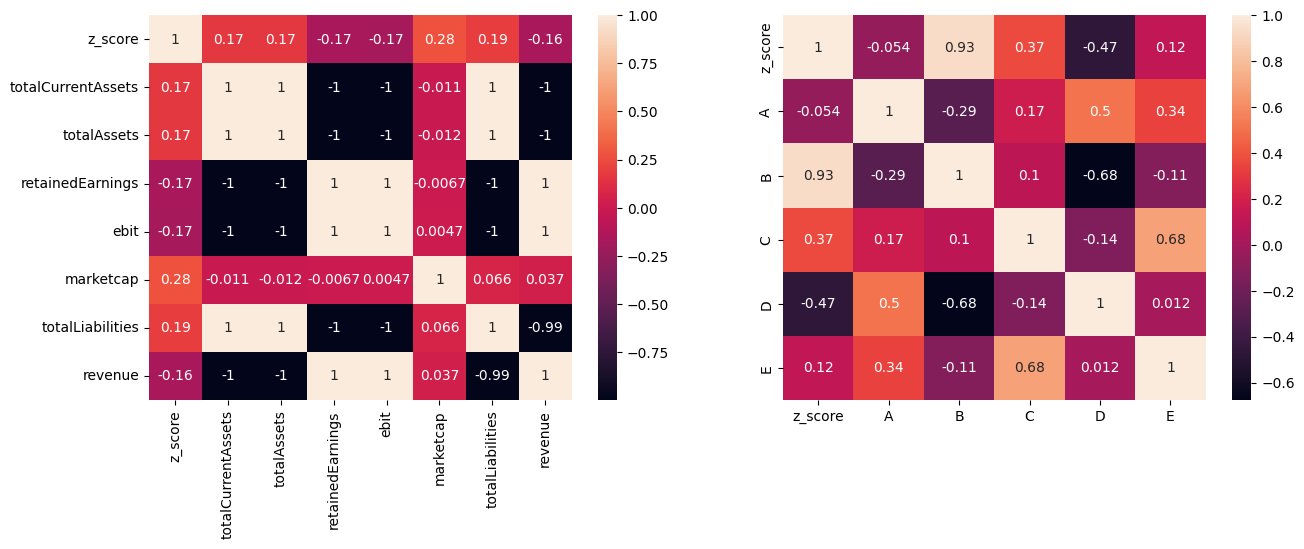

In [12]:
corr_data_raw = negative_z_score_analysis[['z_score', 'totalCurrentAssets', 'totalAssets', 'retainedEarnings', 'ebit', 'marketcap', 'totalLiabilities', 'revenue']]
corr_data_z = negative_z_score_analysis[['z_score','A', 'B', 'C', 'D', 'E']]

matrix1 = corr_data_raw.corr(numeric_only=True)
matrix2 = corr_data_z.corr(numeric_only=True)

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.heatmap(matrix1, annot=True, ax=axs[0])
sns.heatmap(matrix2, annot=True, ax=axs[1])
plt.show()

Now we have to matrices showing correlations between the Altman Z-Score and the datapoints of the companies with negative scores.
The first matrix show the correlations of the datapoints as given in the dataset.
The second matrix shows the correlations of the ratios used by the Altman Z-Score calculation.
Here we see that 'B', the retained Earnings to total Assets ratio has the strongest correlation to the z-score.

Looking at the data, we see that all retained earnings are negative in this subset.

Let's create the second matrix using the entire dataset, and compare two matrices.

C:\Users\bicic\AppData\Local\Temp\ipykernel_12440\2907407665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_z_score_analysis['ebit'] = complete_z_score_analysis['ebitda'] - complete_z_score_analysis['depreciationAndAmortization_income_statement']


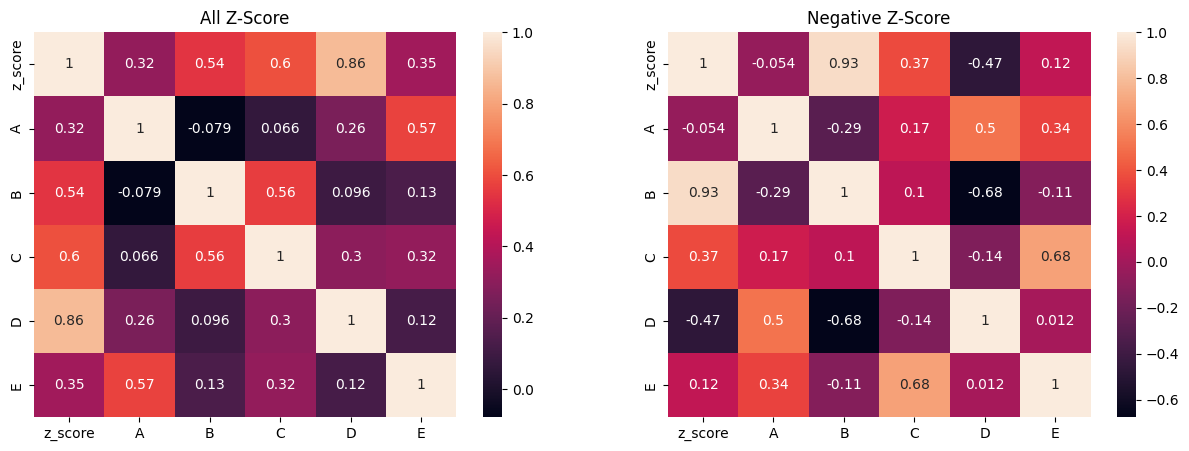

In [13]:
complete_z_score_analysis = df_3std[['symbol', 'year', 'z_score', 'totalCurrentAssets', 'totalAssets', 'retainedEarnings', 'ebitda', 'depreciationAndAmortization_income_statement', 'totalLiabilities', 'marketcap', 'revenue']]
complete_z_score_analysis['ebit'] = complete_z_score_analysis['ebitda'] - complete_z_score_analysis['depreciationAndAmortization_income_statement']
complete_z_score_analysis = complete_z_score_analysis.drop(columns=['ebitda', 'depreciationAndAmortization_income_statement'])
complete_z_score_analysis['A'] = complete_z_score_analysis['totalCurrentAssets'] / complete_z_score_analysis['totalAssets']
complete_z_score_analysis['B'] = complete_z_score_analysis['retainedEarnings'] / complete_z_score_analysis['totalAssets']
complete_z_score_analysis['C'] = complete_z_score_analysis['ebit'] / complete_z_score_analysis['totalAssets']
complete_z_score_analysis['D'] = complete_z_score_analysis['marketcap'] / complete_z_score_analysis['totalLiabilities']
complete_z_score_analysis['E'] = complete_z_score_analysis['revenue'] / complete_z_score_analysis['totalAssets']

complete_corr_data = complete_z_score_analysis[['z_score','A', 'B', 'C', 'D', 'E']]

complete_matrix = complete_corr_data.corr(numeric_only=True)
negative_matrix = corr_data_z.corr(numeric_only=True)

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.heatmap(complete_matrix, annot=True, ax=axs[0])
sns.heatmap(negative_matrix, annot=True, ax=axs[1])
axs[0].set_title('All Z-Score')
axs[1].set_title('Negative Z-Score')
plt.show()

In comparison, the correlation of B is weaker in the full dataset, but it's still decently strong.
The strongest correlation is now D, Market Cap to Total Liabilities ratio. Which I believe logically makes sense, as we're dealing with companies that have been sourced from a high performing index.

Another way to check the data for multicollinearity (not correlation) is to use the variance inflaition factor (VIF).
The VIF cannot deal with empty values, so we will remove them first.

The main dataset has many empty values.
The 3-standard-deviation set has no empty, since the z-score calculation and removal of outliers presumably dealt with them. We will also craete a standardized set for comparison. Since the values in the set have a lot of variance, sttandardizing should hlep with calculations.

In [14]:
scaler = StandardScaler()
#prepare data
#load data to do the VIF analysis
df_3std_vif = df_3std.copy()


#drop columns not required
df_3std_vif.drop(columns=['z_score', 'year'], inplace=True)

#drop missing values (should do nothing, but just in case)
df_3std_vif.dropna(inplace=True)

#get list of numeric columns, and drop non-numeric columns
numeric_columns = df_3std_vif.select_dtypes(include=[np.number]).columns.tolist()
df_3std_vif = df_3std_vif[numeric_columns]

In [15]:
# calculate VIFs
vals1 = [VIF(df_3std_vif, i) for i in range(1, df_3std_vif.shape[1])]
vif = pd.DataFrame({"vif": vals1}, index=df_3std_vif.columns[1:])
vif = vif.sort_values("vif", ascending=False)

vif = vif.round(3)

print(vif.to_markdown())

c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


|                                                 |              vif |
|:------------------------------------------------|-----------------:|
| minorityInterest                                |    inf           |
| totalLiabilitiesAndTotalEquity                  |    inf           |
| totalEquity                                     |    inf           |
| totalLiabilitiesAndStockholdersEquity           |    inf           |
| totalStockholdersEquity                         |    inf           |
| grossProfit                                     |    inf           |
| costOfRevenue                                   |    inf           |
| revenue                                         |    inf           |
| eps                                             |      3.73026e+10 |
| epsdiluted                                      |      3.73018e+10 |
| cashAtEndOfPeriod                               |      2.43386e+07 |
| cashAtBeginningOfPeriod                         |      1.69191e+07 |
| oper

We notice that there are many ridiculously high VIF scores.
Taking a closer look at those values we notice that many of the calculated values (totals, ratios) and the values used for their calculation are part of the group of high VIFs. Let's iterively drop the highest VIF until we reach a reasonable level of VIFs.

In [16]:
df_3std_vif_drop = df_3std.copy()

#drop unnecessary columns
df_3std_vif_drop.drop(columns=['z_score', 'year'], inplace=True)

# note: calculation can take up to 5 minutes
df_3std_trimmed = vif_featuretrimmer(df_3std_vif_drop, 20)

VIF feature trimming started


c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Threshold reached
VIF feature trimming completed

Removed 61 features
Final VIF values:

|     vif | features                                |
|--------:|:----------------------------------------|
| 9.7612  | shortTermDebt                           |
| 9.53261 | accumulatedOtherComprehensiveIncomeLoss |
| 9.18799 | weightedAverageShsOutDil                |
| 9.15672 | totalCurrentLiabilities                 |
| 8.56481 | netDebt                                 |
| 8.17892 | sellingGeneralAndAdministrativeExpenses |
| 8.16075 | commonStockRepurchased                  |
| 7.65369 | propertyPlantEquipmentNet               |
| 7.64664 | othertotalStockholdersEquity            |
| 7.54046 | otherWorkingCapital                     |
| 6.69927 | epsdiluted                              |
| 6.59429 | intangibleAssets                        |
| 6.52691 | otherAssets                             |
| 6.24657 | generalAndAdministrativeExpenses        |
| 5.84516 | totalOtherIncomeExpensesNet        

After removing a large number of features, with a threshold of 10, we are left with 44 features (including 2 possible intercepts in distressed and unhealthy) to create a logistic regression model with.

Let's run a logistic regression.

In [17]:
# create y, the target variable and X, the features
y = list(df_3std_trimmed['unhealthy'])
numeric_columns = df_3std_trimmed.select_dtypes(include=[np.number]).columns.tolist()
X = df_3std_trimmed[numeric_columns]

# dropping targets
X = X.drop(columns=['distressed', 'unhealthy'])
# dropping high correlation features that VIF didn't catch
X = X.drop(columns=['grossProfitRatio', 'ebitdaratio', 'epsdiluted'])
# dropping features as part of model selection
X = X.drop(columns=['researchAndDevelopmentExpenses','shortTermDebt','sellingAndMarketingExpenses','acquisitionsNet','taxPayables','deferredRevenueNonCurrent','otherWorkingCapital','otherAssets','commonStock','effectOfForexChangesOnCash','propertyPlantEquipmentNet','otherCurrentAssets','capitalLeaseObligations','deferredIncomeTax','weightedAverageShsOut', 'weightedAverageShsOutDil', 'commonStockRepurchased', 'othertotalStockholdersEquity'])

# run the logistic regression model
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  712
Model:                            GLM   Df Residuals:                      691
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -331.43
Date:                Sat, 03 May 2025   Deviance:                       662.87
Time:                        13:55:27   Pearson chi2:                 3.57e+03
No. Iterations:                    13   Pseudo R-squ. (CS):             0.3629
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

After doing model selection we now have a decent model. 

In [18]:
#save the model
results.save('models/log_01.pkl')

In [19]:
probs = results.predict(X)
pred_labels = np.array(['0.0']*712)
pred_labels[probs>0.5] = '1.0'

true_labels = df_3std_vif['unhealthy'].values.astype(str)

confusion_table(pred_labels, true_labels)

Truth,0.0,1.0
Predicted,,
0.0,321,60
1.0,59,272


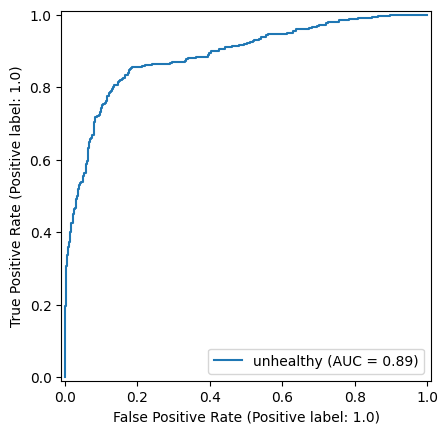

In [20]:
roc_curve = RocCurveDisplay.from_predictions

roc_curve(true_labels, probs, pos_label='1.0', name='unhealthy')

The ROC curve also shows that the model is decent at predicting "unhealthy" companies. However, there is a chance that this is due to the model overfitting. We should separate the data into a training and test set, rerun the model and evaluate the results. We could randomly split the data, but since we do have a time series, we should split the data by time. We can put all data from 2024 into the test set and use the rest for training.

In [21]:
# create test and train datasets
df_test = df_3std[df_3std['year'] == 2024].copy()
df_train = df_3std[df_3std['year'] != 2024].copy()

Let's clean up the data with the same process as before, before running the logistic regression.

In [22]:
numeric_columns = df_train.select_dtypes(include=[np.number]).columns.tolist()
df_train = df_train[numeric_columns]

#drop unnecessary columns
df_train.drop(columns=['z_score', 'year'], inplace=True)

# note: calculation can take up to 5 minutes
df_train_viftrim = vif_featuretrimmer(df_train, 20)

VIF feature trimming started


c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\bicic\Documents\bachelor\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Threshold reached
VIF feature trimming completed

Removed 64 features
Final VIF values:

|     vif | features                                     |
|--------:|:---------------------------------------------|
| 9.59797 | accumulatedOtherComprehensiveIncomeLoss      |
| 9.08169 | weightedAverageShsOutDil                     |
| 8.51272 | othertotalStockholdersEquity                 |
| 7.54335 | generalAndAdministrativeExpenses             |
| 7.41667 | depreciationAndAmortization_income_statement |
| 7.0977  | totalCurrentLiabilities                      |
| 6.81849 | otherNonCurrentAssets                        |
| 6.36284 | commonStockRepurchased                       |
| 6.32973 | intangibleAssets                             |
| 5.42732 | shortTermInvestments                         |
| 5.12655 | costOfRevenue                                |
| 5.01214 | operatingIncome                              |
| 4.45425 | researchAndDevelopmentExpenses               |
| 4.3747  | deferredTaxLia

In [23]:
# create y, the target variable and X, the features
y = list(df_train_viftrim['unhealthy'])
numeric_columns = df_train_viftrim.select_dtypes(include=[np.number]).columns.tolist()
X = df_train_viftrim[numeric_columns]

# dropping targets
X = X.drop(columns=['distressed', 'unhealthy'])
# dropping high correlation features that VIF didn't catch
X = X.drop(columns=['otherNonCurrentAssets', 'grossProfitRatio', 'ebitdaratio'])
# dropping features as part of model selection
X = X.drop(columns=['deferredRevenue','shortTermInvestments','salesMaturitiesOfInvestments','intangibleAssets','deferredIncomeTax','depreciationAndAmortization_income_statement','accumulatedOtherComprehensiveIncomeLoss','deferredRevenueNonCurrent','accountsReceivables','effectOfForexChangesOnCash','taxPayables','weightedAverageShsOutDil','totalCurrentLiabilities'])
# run the logistic regression model
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()

print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  653
Model:                            GLM   Df Residuals:                      630
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -240.70
Date:                Sat, 03 May 2025   Deviance:                       481.40
Time:                        13:58:49   Pearson chi2:                     816.
No. Iterations:                    12   Pseudo R-squ. (CS):             0.4758
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
cashAndC

In [24]:
#save the model
results.save('models/log_02.pkl')

In [25]:
#remove columns in the test set to match the train set
columns_tokeep = [
    "cashAndCashEquivalents",
    "otherCurrentAssets",
    "deferredTaxLiabilitiesNonCurrent",
    "capitalLeaseObligations",
    "preferredStock",
    "commonStock",
    "othertotalStockholdersEquity",
    "minorityInterest",
    "stockBasedCompensation",
    "inventory_cash_flow_statement",
    "accountsPayables",
    "acquisitionsNet",
    "commonStockRepurchased",
    "otherFinancingActivites",
    "costOfRevenue",
    "researchAndDevelopmentExpenses",
    "generalAndAdministrativeExpenses",
    "sellingAndMarketingExpenses",
    "operatingExpenses",
    "operatingIncome",
    "totalOtherIncomeExpensesNet",
    "incomeTaxExpense",
    "weightedAverageShsOut"
]

df_test_model = df_test[columns_tokeep].copy()

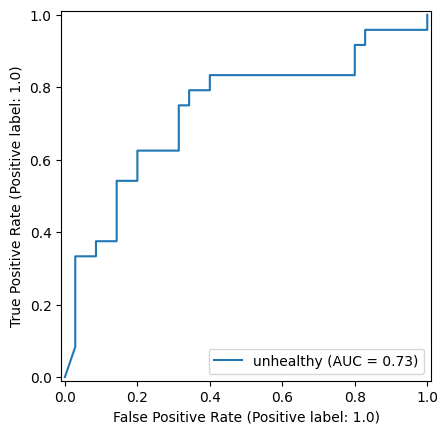

In [26]:
probs = results.predict(exog=df_test_model)
true_labels = df_test['unhealthy'].values.astype(str)

roc_curve(true_labels, probs, pos_label='1.0', name='unhealthy')

On the test set we the model ends up being a bit worse.